# COVID-19 risk factors

Coronavirus is a serious public health threat to countries worldwide and rapid action must be taken to avoid the collapse of health care systems.

There are numerous studies released every day containing information on the risk factors, transmission, incubation, diagnostics, potential vaccines and therapeutics, to just name a few of the topics covered.

However, with the increasing number of research papers it is become more and more difficult for humans to combed through the sheer mass of information and find patterns in the findings. Therefore, AI is needed to speed up the process and generate valuable insights from these studies.



In [26]:
import numpy as np
import pandas as pd
from glob import glob
import config
import json
import re

from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sb


## Load data

In [2]:
# read in the metadata
df_meta = pd.read_csv('metadata.csv')
df_meta.head()


,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file
0,NaN,Elsevier,Intrauterine virus infections and congenital h...,10.1016/0002-8703(72)90077-4,NaN,4361535.0,els-covid,Abstract The etiologic basis for the vast majo...,1972-12-31,"Overall, James C.",American Heart Journal,NaN,NaN,False,custom_license
1,NaN,Elsevier,Coronaviruses in Balkan nephritis,10.1016/0002-8703(80)90355-5,NaN,6243850.0,els-covid,NaN,1980-03-31,"Georgescu, Leonida; Diosi, Peter; Buţiu, Ioan;...",American Heart Journal,NaN,NaN,False,custom_license
2,NaN,Elsevier,Cigarette smoking and coronary heart disease: ...,10.1016/0002-8703(80)90356-7,NaN,7355701.0,els-covid,NaN,1980-03-31,"Friedman, Gary D",American Heart Journal,NaN,NaN,False,custom_license
3,aecbc613ebdab36753235197ffb4f35734b5ca63,Elsevier,Clinical and immunologic studies in identical ...,10.1016/0002-9343(73)90176-9,NaN,4579077.0,els-covid,"Abstract Middle-aged female identical twins, o...",1973-08-31,"Brunner, Carolyn M.; Horwitz, David A.; Shann,...",The American Journal of Medicine,NaN,NaN,True,custom_license
4,NaN,Elsevier,Epidemiology of community-acquired respiratory...,10.1016/0002-9343(85)90361-4,NaN,4014285.0,els-covid,Abstract Upper respiratory tract infections ar...,1985-06-28,"Garibaldi, Richard A.",The American Journal of Medicine,NaN,NaN,False,custom_license


In [3]:
# read in the json schema
with open('json_schema.txt') as open_json:
    json_schema = list(open_json)


In [4]:
# read in the studies
studies_all = glob(config.global_path+'**/*.json', recursive=True)
len(studies_all)


29315

In [5]:
# read in the first study and create dataframe for studies
with open(studies_all[0]) as file:
    first_study = json.load(file)
    
df_studies = pd.DataFrame.from_dict(first_study, orient='index').T
df_studies


,paper_id,metadata,abstract,body_text,bib_entries,ref_entries,back_matter
0,0015023cc06b5362d332b3baf348d11567ca2fbb,{'title': 'The RNA pseudoknots in foot-and-mou...,[{'text': 'word count: 194 22 Text word count:...,"[{'text': 'VP3, and VP0 (which is further proc...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Genetic...",{'FIGREF0': {'text': 'and-mouth disease virus ...,[{'text': 'author/funder. All rights reserved....


In [6]:
# add individual studies into one list
studies_list = []

for study in studies_all[1:]:
    df_temp = pd.read_json(study, orient='index').T
    df_studies = pd.concat([df_studies, df_temp], ignore_index=True)


C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [7]:
# remove any unwanted column
df_studies.drop(columns=['back_matter', 'bib_entries', 'ref_entries'], inplace=True)



In [8]:
# create new columns
df_studies['abstract_text'] = df_studies['abstract'].apply(lambda x: ','.join([i['text'] for i in x]) if x != [] else np.nan)
df_studies['title'] = df_studies['metadata'].apply(lambda x: x['title'] if (x != {} or x['title'] != '')  else np.nan)
df_studies['authors'] = df_studies['metadata'].apply(lambda x: x['authors'] if x != [] else np.nan)
df_studies['authors_list'] = df_studies['authors'].apply(lambda x: [' '.join([value if type(value) == str else 
                                                                    (value[0] if (len(value) > 0 and type(value) == list) 
                                                                    else (value+'; ' if key == 'last' else ''))
                                                                    for key, value in i.items()]).strip() for i in x]
                                                                    if x != [] else np.nan)
df_studies['full_text'] = df_studies['body_text'].apply(lambda x: ' '.join(['\n'.join([value if key == 'text' else ''
                                                                              for key, value in i.items()]) for i in x])
                                                                              if x != [] else np.nan)


In [9]:
#drop any irrelevant columns
df_studies.drop(columns=['authors', 'body_text', 'metadata', 'abstract'], inplace=True)


In [10]:
# creating a temporary dataframe with sha and journal
df_meta_journal = df_meta[['sha', 'journal']].copy()
# merging the journal to the matching paper
df_meta_journal.rename(columns={'sha': 'paper_id'}, inplace=True)
df_data = df_studies.merge(df_meta_journal, on='paper_id', how='inner')

In [11]:
df_data['full_text'][0]

'VP3, and VP0 (which is further processed to VP2 and VP4 during virus assembly) (6). The P2 64 and P3 regions encode the non-structural proteins 2B and 2C and 3A, 3B (1-3) (VPg), 3C pro and 4 structural protein-coding region is replaced by reporter genes, allow the study of genome 68 replication without the requirement for high containment (9, 10) ( figure 1A ).\n\n\n The FMDV 5′ UTR is the largest known picornavirus UTR, comprising approximately 1300 71 nucleotides and containing several highly structured regions. The first 360 nucleotides at the 5′ 72 end are predicted to fold into a single large stem loop termed the S-fragment, followed by a The PKs were originally predicted in 1987 and consist of two to four tandem repeats of a ~48 86 nucleotide region containing a small stem loop and downstream interaction site (figure 1B) 87 (12). Due to the sequence similarity between the PKs (figure 1C), it is speculated that they 88 were formed by duplication events during viral replication, p

In [12]:
# overview of new dataframe
df_data.head()


,paper_id,abstract_text,title,authors_list,full_text,journal
0,0015023cc06b5362d332b3baf348d11567ca2fbb,word count: 194 22 Text word count: 5168 23 24...,The RNA pseudoknots in foot-and-mouth disease ...,"[Joseph C Ward, Lidia Lasecka-Dykes, Chris N...","VP3, and VP0 (which is further processed to VP...",NaN
1,004f0f8bb66cf446678dc13cf2701feec4f36d76,NaN,Healthcare-resource-adjusted vulnerabilities t...,"[Hanchu Zhou, Jiannan Yang, Kaicheng Tang, ...",The 2019-nCoV epidemic has spread across China...,NaN
2,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...,"Real-time, MinION-based, amplicon sequencing f...","[Salman L Butt, Eric C Erwood, Jian Zhang, Ho...","Infectious bronchitis (IB), which is caused by...",NaN
3,0139ea4ca580af99b602c6435368e7fdbefacb03,Nipah Virus (NiV) came into limelight recently...,A Combined Evidence Approach to Prioritize Nip...,"[Nishi Kumari, Ayush Upadhyay, Kishan Kalia...",Nipah is an infectious negative-sense single-s...,NaN
4,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,Background: A novel coronavirus (2019-nCoV) em...,Assessing spread risk of Wuhan novel coronavir...,"[Shengjie Lai, Isaac I Bogoch, Nick W Ruktano...","In December 2019, a cluster of patients with p...",NaN


## Preprocessing

### Missing values

In [13]:
# get an overview of NaNs in dataset
df_data.isnull().sum()


paper_id            0
abstract_text    7462
title               0
authors_list     2941
full_text           0
journal           894
dtype: int64

In [14]:
# see how many titles are missing
df_data[df_data['title'] == ''].shape


(3390, 6)

In [15]:
# see how many paper_ids are missing
for item in df_data['paper_id']:
    if len(item) < 5:
        print(item)


In [16]:
# see how many paper_ids are missing
for item in df_data['full_text']:
    if len(item) < 5:
        print(item)
        

The important part is the full text so it is good to know which other variables have missing data, but there is no need to take any action for now.

### Duplicate values

In [17]:
# check whether there are any duplicate full_texts
df_data[df_data['full_text'].duplicated() == True]


,paper_id,abstract_text,title,authors_list,full_text,journal
8279,e1e11bdec2d27ec0b9675e684fc2653513a029bd,NaN,Is It Just a Marker for Increased Care?,[Richard Hockey],Because the increased prescriptions of antidep...,PLoS Med
12658,34ba72963a44bbe5ce71b7ec96c6f71dd1069c2e,"RATIONALE: In infancy, rhinovirus illnesses an...",574 Coronavirus NL63 Illnesses in Infancy are ...,"[T E Pappas, K T Sullivan Dille, W Lee, K A G...",p 5 0.005) prevalence in children who needed t...,Journal of Allergy and Clinical Immunology
13806,45e40b2d7d973ed5c9798da613fb3cfa4427e2e2,NaN,,"[E J Corey, Xue-Min Cheng]",A digestible vaccine sandwich VACCINE BIOTECHN...,Trends in Biotechnology
13846,4644c32551fb23aa873a7738ecc8d777bd49877e,NaN,PIV-33 Detection of oseltamivir-resistant infl...,"[A Carhan, N Albayrak, A B Altas, Y Uyar, R...","S15-S61 A. Carhan *, N. Albayrak, A.B. Altas, ...",Journal of Clinical Virology
13847,4644c32551fb23aa873a7738ecc8d777bd49877e,NaN,PIV-33 Detection of oseltamivir-resistant infl...,"[A Carhan, N Albayrak, A B Altas, Y Uyar, R...","S15-S61 A. Carhan *, N. Albayrak, A.B. Altas, ...",Journal of Clinical Virology
13848,4644c32551fb23aa873a7738ecc8d777bd49877e,NaN,PIV-33 Detection of oseltamivir-resistant infl...,"[A Carhan, N Albayrak, A B Altas, Y Uyar, R...","S15-S61 A. Carhan *, N. Albayrak, A.B. Altas, ...",Journal of Clinical Virology
14715,544de0b37a1bfef02405733cf09c673c0fffd7d2,NaN,Letters to the Editor Emergence of a novel cor...,NaN,"In previous reports, workers have characterize...",Journal of Infection
16050,68b9d6c200af25c4f58f2b13e0649d7f2faec4e6,"publicly funded repositories, such as the WHO ...",Pneumonia aguda fibrinosa e organizante Pneumo...,"[Cláudia Santos, Fátima Fradinho, Alexandra ...",A Pneumonia Aguda Fibrinosa e Organizante (AFO...,Revista Portuguesa de Pneumologia (English Edi...
16692,72a5640aa0c307fbe171ca7ad55d3fda48b53988,During invasive mechanical ventilation due to ...,P1 The conditioning of medical gases with hot ...,"[D Chiumello, M Cressoni, C De Grandis, L ...",A bougie was used during 46. This technique do...,Crit Care
16693,72a5640aa0c307fbe171ca7ad55d3fda48b53988,During invasive mechanical ventilation due to ...,P1 The conditioning of medical gases with hot ...,"[D Chiumello, M Cressoni, C De Grandis, L ...",A bougie was used during 46. This technique do...,Crit Care


In [18]:
# remove all duplicate full texts
df_data.drop_duplicates(subset=['full_text'], keep='first', inplace=True)


In [19]:
# check the number of remaining rows
print(df_data.shape)

# check whether there are any duplicates left
print(df_data[df_data['paper_id'].duplicated() == True])
print(df_data[df_data['full_text'].duplicated() == True])


(27662, 6)
Empty DataFrame
Columns: [paper_id, abstract_text, title, authors_list, full_text, journal]
Index: []
Empty DataFrame
Columns: [paper_id, abstract_text, title, authors_list, full_text, journal]
Index: []


### Cleaning and normalizing full text

In [40]:
# removing any phrases that are not related to the actual content
df_data['cleaned_text'] = df_data['full_text'].apply(lambda x: re.sub('The copyright.+preprint', '', x))
df_data['cleaned_text'] = df_data['cleaned_text'].apply(lambda x: re.sub('All rights reserved. No reuse allowed without permission.', '', x))
df_data['cleaned_text'] = df_data['cleaned_text'].apply(lambda x: re.sub('The copyright.+ author/funder', '', x))
df_data['cleaned_text'] = df_data['cleaned_text'].apply(lambda x: re.sub('This article is a US Government work.+a CC0 license', '', x))


In [41]:
# check whether removal worked
#df_data[df_data['cleaned_text'].str.contains('The copyright')]


In [42]:
# Normalize the text by converting all letters to lower case
df_data['cleaned_text'] = df_data['cleaned_text'].apply(lambda x: x.lower())
# Remove all punctuation and add spaces instead
df_data['cleaned_text'] = df_data['cleaned_text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]', ' ', x))
# Remove any excess white space including tabs and creating list of words in text
df_data['cleaned_text'] = df_data['cleaned_text'].apply(lambda x: x.split())
# Lemmatizing words
lemmatizer = WordNetLemmatizer()
df_data['cleaned_text'] = df_data['cleaned_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])


In [43]:
df_data['cleaned_text'][0]

['vp3',
 'and',
 'vp0',
 'which',
 'is',
 'further',
 'processed',
 'to',
 'vp2',
 'and',
 'vp4',
 'during',
 'virus',
 'assembly',
 '6',
 'the',
 'p2',
 '64',
 'and',
 'p3',
 'region',
 'encode',
 'the',
 'non',
 'structural',
 'protein',
 '2b',
 'and',
 '2c',
 'and',
 '3a',
 '3b',
 '1',
 '3',
 'vpg',
 '3c',
 'pro',
 'and',
 '4',
 'structural',
 'protein',
 'coding',
 'region',
 'is',
 'replaced',
 'by',
 'reporter',
 'gene',
 'allow',
 'the',
 'study',
 'of',
 'genome',
 '68',
 'replication',
 'without',
 'the',
 'requirement',
 'for',
 'high',
 'containment',
 '9',
 '10',
 'figure',
 '1a',
 'the',
 'fmdv',
 '5',
 'utr',
 'is',
 'the',
 'largest',
 'known',
 'picornavirus',
 'utr',
 'comprising',
 'approximately',
 '1300',
 '71',
 'nucleotide',
 'and',
 'containing',
 'several',
 'highly',
 'structured',
 'region',
 'the',
 'first',
 '360',
 'nucleotide',
 'at',
 'the',
 '5',
 '72',
 'end',
 'are',
 'predicted',
 'to',
 'fold',
 'into',
 'a',
 'single',
 'large',
 'stem',
 'loop',
 '

In [ ]:
# Create function that tokenizes text input
# Adapted from https://github.com/julianikulski/disaster-response-pipeline/blob/master/ML%20Pipeline%20Preparation.ipynb
def tokenize(text):
    '''
    Function splitting text into words, converting to lower case and removing punctuation
    Args: text = message in form of string
    Return: clean_tokens = list of cleaned tokens
    '''
    
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    
    clean_tokens = []
    for token in tokens:
        clean_token = lemmatizer.lemmatize(token).lower().strip()
        clean_tokens.append(clean_token)
        
    return clean_tokens

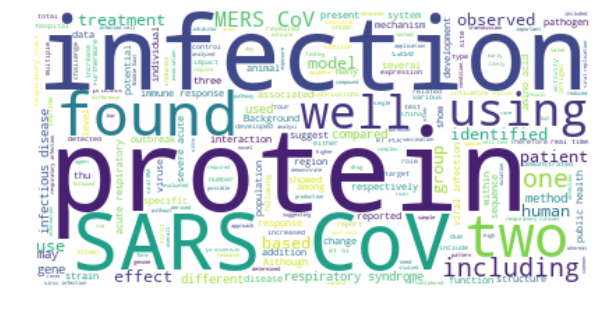

In [24]:
# create a wordcloud
add_words = ['method', 'results', 'conclusion']
stop_words = STOPWORDS.union(add_words)
abstract_words = df_data['abstract_text'].str.cat(sep='. ')
wordcloud = WordCloud(stopwords=stop_words, random_state=42, background_color='white').generate(abstract_words)

plt.figure(figsize=[10,6])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## Preprocessing for model

## Modelling

## Evaluation